In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score

In [ ]:
"""Assign categories: If the opinion distribution has 
	 - 1 peak and a low variance 	-->		0. consensus state
	 - 1 peak and a high variance	-->		1. co-existence state
	 - 2+ peaks						-->		2. polarized state"""
def	load_data(path="final"):
	"""Load the datasets, clean up"""
	data = pd.read_csv(f"results/{path}/results.csv")
	data = data.loc[:, data.columns != 'Modelrun']
	data['Degree'] = data['Unity']
	data.loc[data['State'] == 0, 'State'] = "Consensus"
	data.loc[data['State'] == 1, 'State'] = "Co-existence"
	data.loc[data['State'] == 2, 'State'] = "Polarisation"
	data['Index'] = data.index
	return data

In [22]:
base = load_data("final")
extra = load_data("extra")
df = pd.concat([base, extra])
df.loc[:, df.columns != 'State']
print(df.describe().drop('count'))
print(df['State'].value_counts())

        OPmean  OPvariance       Unity  GenTlambda        Runs      Degree  \
mean -0.000074    0.244966  570.788849    0.480319   96.319571  570.788849   
std   0.066234    0.041321   13.211828    0.298279   13.993435   13.211828   
min  -0.267530    0.071730  525.000000    0.000000   13.000000  525.000000   
25%  -0.045040    0.219668  562.000000    0.213500  100.000000  562.000000   
50%   0.000165    0.246070  571.500000    0.479500  100.000000  571.500000   
75%   0.040915    0.272833  580.000000    0.733250  100.000000  580.000000   
max   0.272830    0.379630  612.500000    1.000000  100.000000  612.500000   

            Index  
mean   809.239922  
std    508.136251  
min      0.000000  
25%    384.000000  
50%    768.500000  
75%   1153.000000  
max   1891.000000  
State
Co-existence    1774
Polarisation    1302
Name: count, dtype: int64


C:\Users\jelle\AppData\Local\Temp\ipykernel_3156\745072766.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Consensus' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['State'] == 0, 'State'] = "Consensus"
C:\Users\jelle\AppData\Local\Temp\ipykernel_3156\745072766.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Consensus' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data['State'] == 0, 'State'] = "Consensus"


In [23]:
num_bins = 20
bins = np.linspace(df['GenTlambda'].min(), df['GenTlambda'].max(), num_bins + 1)
df['GenTlambda_binned'] = pd.cut(df['GenTlambda'], bins, include_lowest=False)

# Group by binned GenTlambda and State
counts = df.groupby(['GenTlambda_binned', 'State']).size().unstack(fill_value=0)
probabilities = counts.div(counts.sum(axis=1), axis=0)

# Calculate error margin (standard error) for each bin
bin_counts = df.groupby('GenTlambda_binned').size()
error_margin = np.sqrt(probabilities * (1 - probabilities) / bin_counts.values[:, None])

print(probabilities)

coexistences = probabilities["Co-existence"]
polarisations = probabilities["Polarisation"]

State              Co-existence  Polarisation
GenTlambda_binned                            
(0.0, 0.05]            0.410526      0.589474
(0.05, 0.1]            0.510638      0.489362
(0.1, 0.15]            0.385321      0.614679
(0.15, 0.2]            0.530000      0.470000
(0.2, 0.25]            0.541667      0.458333
(0.25, 0.3]            0.536585      0.463415
(0.3, 0.35]            0.547368      0.452632
(0.35, 0.4]            0.500000      0.500000
(0.4, 0.45]            0.574468      0.425532
(0.45, 0.5]            0.578947      0.421053
(0.5, 0.55]            0.641975      0.358025
(0.55, 0.6]            0.622549      0.377451
(0.6, 0.65]            0.588235      0.411765
(0.65, 0.7]            0.711230      0.288770
(0.7, 0.75]            0.626263      0.373737
(0.75, 0.8]            0.630542      0.369458
(0.8, 0.85]            0.642857      0.357143
(0.85, 0.9]            0.684492      0.315508
(0.9, 0.95]            0.724138      0.275862
(0.95, 1.0]            0.696429   

C:\Users\jelle\AppData\Local\Temp\ipykernel_3156\1518408590.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby(['GenTlambda_binned', 'State']).size().unstack(fill_value=0)
C:\Users\jelle\AppData\Local\Temp\ipykernel_3156\1518408590.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = df.groupby('GenTlambda_binned').size()


C:\Users\jelle\AppData\Local\Temp\ipykernel_3156\3742634191.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  degree_spread = df.groupby(['GenTlambda_binned', 'State'])['Degree'].std().unstack()


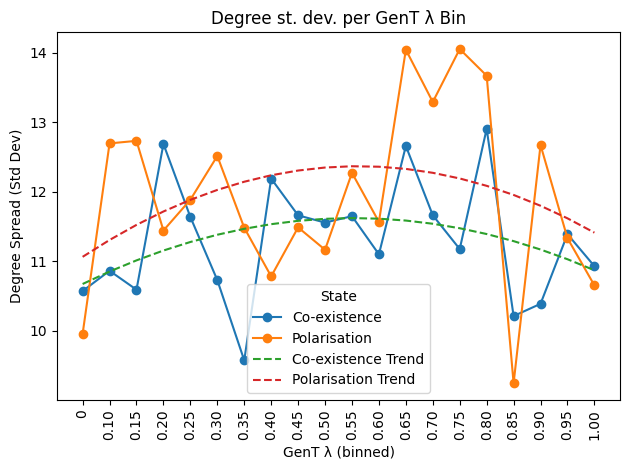

In [24]:
categories = df['State'].unique()
cat_n = len(categories)

# Calculate Degree spread (standard deviation) per GenTlambda bin, per State
degree_spread = df.groupby(['GenTlambda_binned', 'State'])['Degree'].std().unstack()

degree_spread.plot(kind='line', marker='o')

# Add quadratic trendline (2nd degree)
for cat in categories:
	y = degree_spread[cat].values
	x = np.arange(len(y))
	coeffs = np.polyfit(x, y, 2)
	trend = np.poly1d(coeffs)
	plt.plot(x, trend(x), linestyle='--', label=f'{cat} Trend')

plt.xlabel('GenT λ (binned)')
plt.ylabel('Degree Spread (Std Dev)')
plt.title('Degree st. dev. per GenT λ Bin')
plt.xticks(ticks=range(len(degree_spread.index)), labels=custom_labels, rotation=90)
plt.legend(title='State')
plt.tight_layout()
plt.savefig('statresults/degree_spread.png')
plt.show()

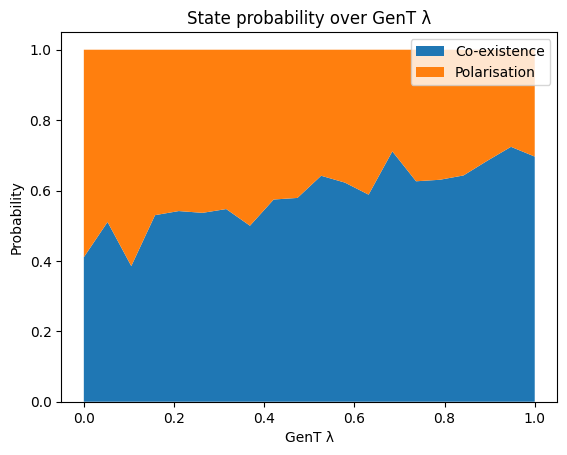

In [25]:
# Simulated data

paramnr = np.linspace(0, 1, 20)

# Stack the values
plt.stackplot(paramnr, coexistences, polarisations, labels=categories, colors=['#1f77b4', '#ff7f0e', "#1c6c1b"])
plt.legend(loc='upper right')
plt.xlabel('GenT λ')
plt.ylabel('Probability')
plt.title('State probability over GenT λ')
plt.savefig('statresults/stateprobs.png')
plt.show()

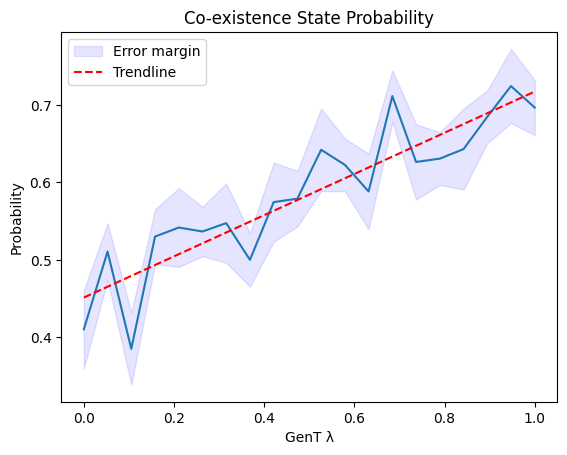

In [26]:
plt.plot(paramnr, coexistences.values)
plt.title('Co-existence State Probability')
plt.xlabel('GenT λ')
plt.ylabel('Probability')
plt.fill_between(paramnr,
				 coexistences.values - error_margin['Co-existence'].values,
				 coexistences.values + error_margin['Co-existence'].values,
				 color='blue', alpha=0.1, label='Error margin')

# Add a quadratic trendline
z = np.polyfit(paramnr, coexistences.values, 1)
p = np.poly1d(z)
plt.plot(paramnr, p(paramnr), color='red', linestyle='--', label='Trendline')

plt.legend()
plt.savefig('statresults/stateprob.png')
plt.show()

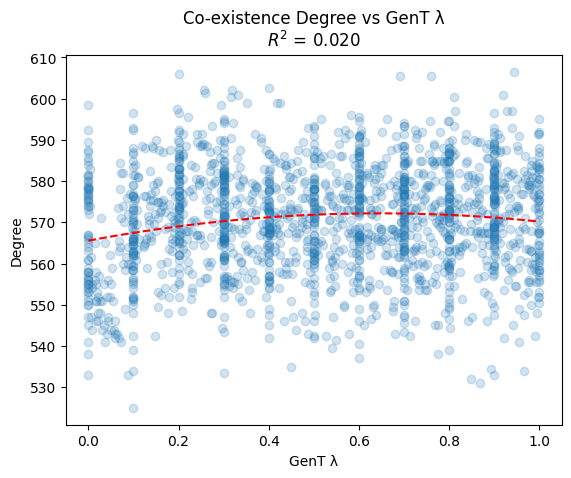

In [27]:
# Make a scatterplot for the State with all datapoints
unity_set_c = df[df['State'] == 'Co-existence']['Degree']
gent_set_c = df[df['State'] == 'Co-existence']['GenTlambda'].sort_values()
plt.scatter(gent_set_c, unity_set_c, alpha=0.2)

plt.xlabel('GenT λ')
plt.ylabel('Degree')
z = np.polyfit(gent_set_c, unity_set_c, 2)
p = np.poly1d(z)
r2 = r2_score(unity_set_c, p(gent_set_c))
plt.title(f'Co-existence Degree vs GenT λ\n$R^2$ = {r2:.3f}')
plt.plot(gent_set_c, p(gent_set_c), color='red', linestyle='--', label='Trendline')
plt.savefig('statresults/co-exdegree.png')
plt.show()

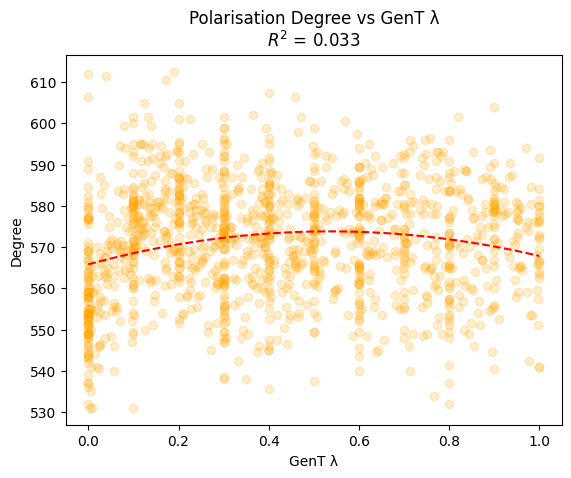

In [28]:
unity_set_p = df[df['State'] == 'Polarisation']['Unity']
gent_set_p = df[df['State'] == 'Polarisation']['GenTlambda'].sort_values()
plt.scatter(gent_set_p, unity_set_p, color="orange", alpha=0.2)

plt.xlabel('GenT λ')
plt.ylabel('Degree')
z = np.polyfit(gent_set_p, unity_set_p, 2)
p = np.poly1d(z)
r2 = r2_score(unity_set_p, p(gent_set_p))
plt.title(f'Polarisation Degree vs GenT λ\n$R^2$ = {r2:.3f}')
plt.plot(gent_set_p, p(gent_set_p), color='red', linestyle='--', label='Trendline')
plt.savefig('statresults/polardegree.png')
plt.show()

C:\Users\jelle\AppData\Local\Temp\ipykernel_3156\35548215.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_runtime_binned = df.groupby('GenTlambda_binned')['Runs'].mean()


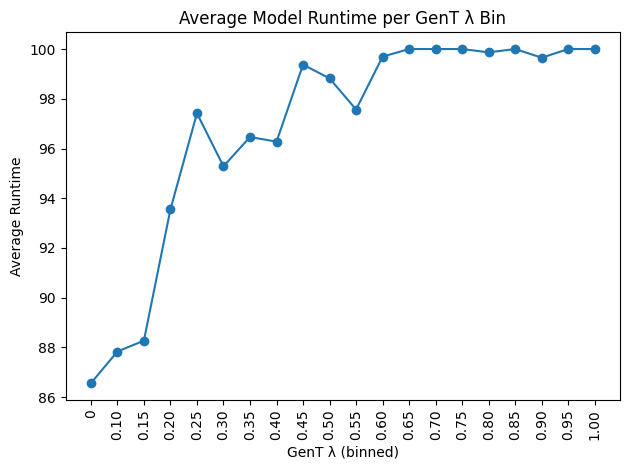

In [29]:
# Bin GenTlambda per 0.05 and calculate average runtime per bin
df['GenTlambda_binned'] = pd.cut(df['GenTlambda'], bins, include_lowest=True)
avg_runtime_binned = df.groupby('GenTlambda_binned')['Runs'].mean()
# Custom x-axis labels: use the bin centers as string labels
custom_labels = []
for i, interval in enumerate(avg_runtime_binned.index):
	if i == 0:
		custom_labels.append("0")
	else:
		custom_labels.append(f"{interval.right:.2f}")

plt.plot(avg_runtime_binned.index.astype(str), avg_runtime_binned.values, marker='o')
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels, rotation=90)
plt.xlabel('GenT λ (binned)')
plt.ylabel('Average Runtime')
plt.title('Average Model Runtime per GenT λ Bin')
plt.tight_layout()
plt.savefig('statresults/runtime.png')
plt.show()